In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time

import sys
sys.path.insert(0, '../')

In [2]:
from libra import ObservationArchive, mask_simultaneous_transits, transit_model, trappist1

In [3]:

def model(params, planet, times):
    original_params = trappist1(planet)
    amp, depth, t0, c0, c1 = params
    original_params.rp = depth**0.5
    original_params.t0 = t0
    
    t = times - times.mean()
    
    fluxes = (amp * transit_model(times, original_params) + 
              c0 * t +  c1 * t**2)
    
    return fluxes

def chi2(params, planet, times, observed_fluxes, obs_err):
    model_fluxes = model(params, planet, times)
    return np.sum( (model_fluxes - observed_fluxes)**2 / obs_err**2)

In [4]:
from scipy.optimize import fmin_l_bfgs_b

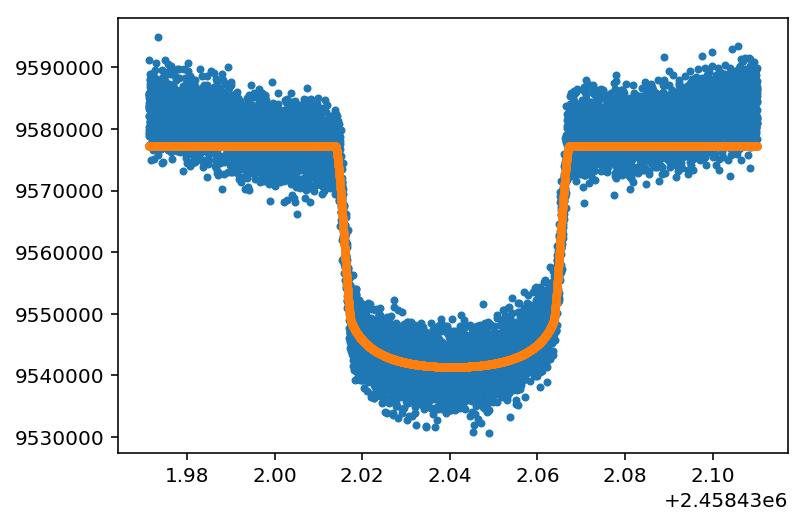

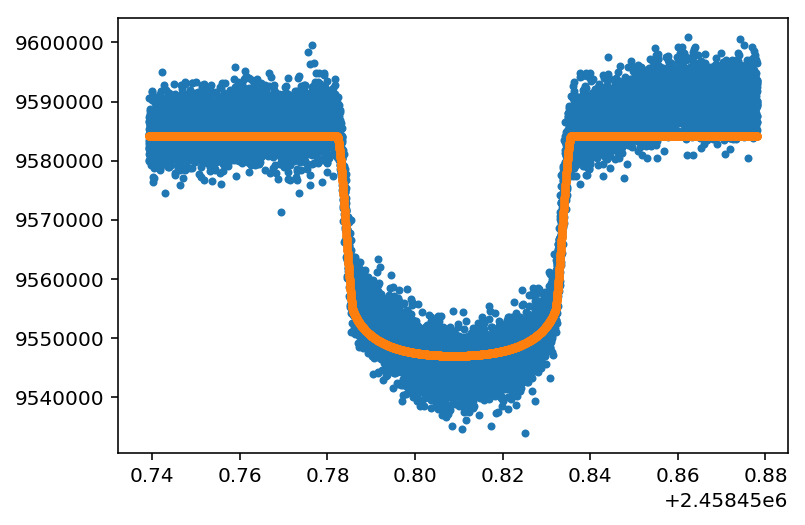

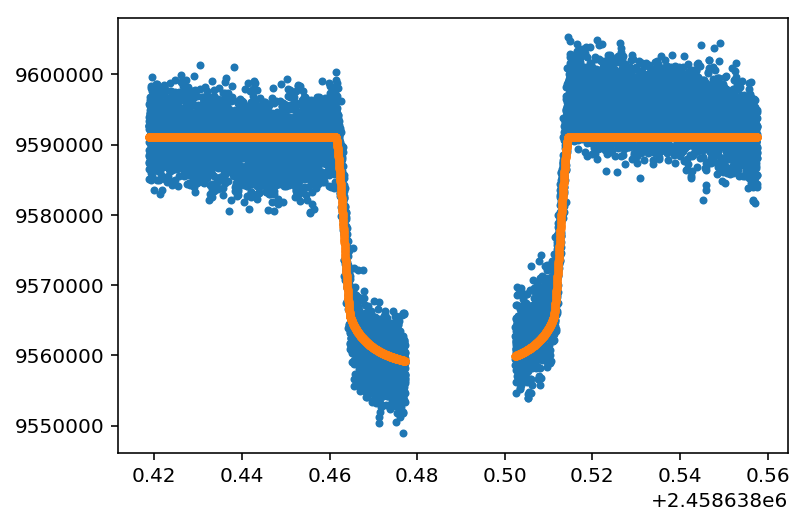

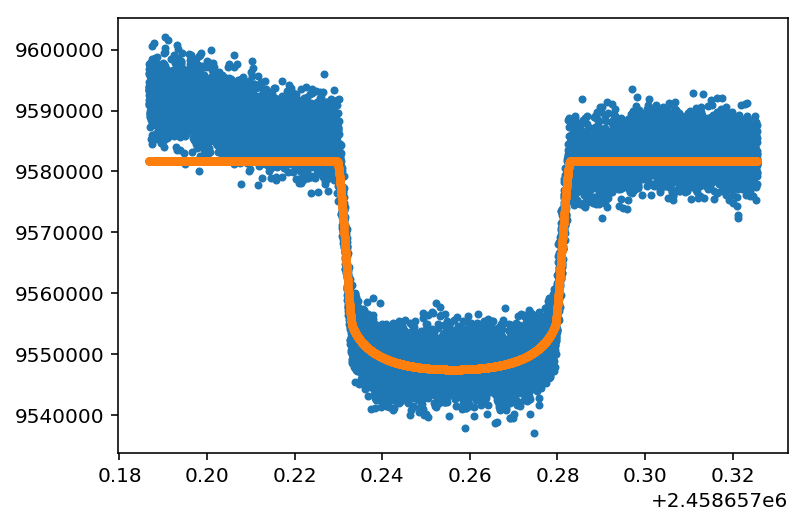

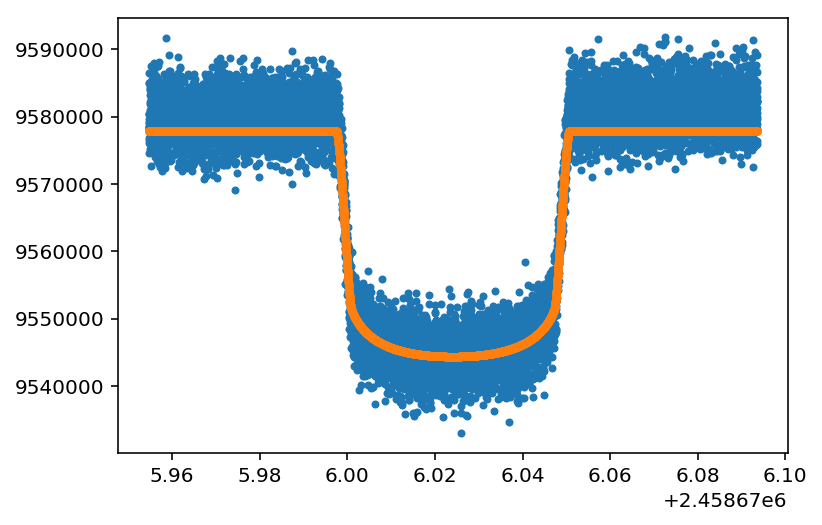

In [192]:
run_name = 'trappist1_bright'

with ObservationArchive(run_name, 'a') as obs:
    planet = 'h'
    for obs_planet in getattr(obs, planet):
        mask = mask_simultaneous_transits(obs_planet.times, planet)
        obs_time = obs_planet.times[mask]
        obs_flux = np.sum(obs_planet.spectra[mask], axis=1)
        obs_err = np.sqrt(obs_flux)
        
        params = trappist1(planet)
        initp = [np.median(obs_flux), params.rp**2, params.t0, 0, 0]
        bounds = [[np.min(obs_flux), np.max(obs_flux)], 
                  [0.9 * params.rp**2, 1.1 * params.rp**2],
                  [params.t0 - 0.1, params.t0 + 0.1], 
                  [-10, 10], [-10, 10]]
        
        result = fmin_l_bfgs_b(chi2, initp, args=(planet, obs_time, obs_flux, obs_err), 
                               approx_grad=True, bounds=bounds)[0]
        
        plt.plot(obs_time, obs_flux, '.')

        plt.plot(obs_time, model(result, planet, obs_time), '.')

        plt.show()

In [208]:
from celerite.modeling import Model
from copy import deepcopy

original_params = trappist1('h')

# Define the model
# class MeanModel(Model):
#     parameter_names = ['amp', 'depth', 't0', 'c0', 'c1']

#     def get_value(self, t):
#         original_params.rp = self.depth**0.5
#         original_params.t0 = self.t0
#         times = t - t.mean()
#         return (self.amp * transit_model(t, original_params) + 
#                 self.c0 * times +  self.c1 * times**2)

class MeanModel(Model):
    parameter_names = ['amp', 'depth', 't0']

    def get_value(self, t):
        params = deepcopy(original_params)
        params.rp = self.depth**0.5
        params.t0 = self.t0
        times = t - t.mean()
        return self.amp * transit_model(t, params)

In [209]:
# import celerite
# from celerite import terms
# from scipy.optimize import minimize

# initp_dict = dict(depth=original_params.rp**2, t0=original_params.t0)

# parameter_bounds = dict(depth=[0.5 * original_params.rp**2, 1.5 * original_params.rp**2],
#                         t0=[original_params.t0 - 0.5, original_params.t0 + 0.5])

# mean_model = MeanModel(**initp_dict, bounds=parameter_bounds)

# x = obs_time
# y = obs_flux
# yerr = obs_err/2

# # Set up the GP model
# # kernel = terms.Matern32Term(log_sigma=np.log(obs_err.mean()), log_rho=2,
# #                             bounds=dict(log_sigma=(-100, 0), log_rho=(np.log(0.1), np.log(5))))

# kernel = terms.Matern32Term(log_sigma=np.log(obs_err.mean()), log_rho=np.log(0.01),
#                             bounds=dict(log_sigma=(None, 10), log_rho=(None, np.log(0.01))))

# # kernel = terms.RealTerm(log_a=-5, log_c=-5)# + 

# # kernel = terms.RealTerm(log_a=-5, log_c=-5)
# gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
# gp.compute(x, yerr)
# print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))

# # Define a cost function
# def neg_log_like(params, y, gp):
#     gp.set_parameter_vector(params)
#     return -gp.log_likelihood(y)

# def grad_neg_log_like(params, y, gp):
#     gp.set_parameter_vector(params)
#     return -gp.grad_log_likelihood(y)[1]

# # Fit for the maximum likelihood parameters
# initial_params = gp.get_parameter_vector()
# bounds = gp.get_parameter_bounds()
# soln = minimize(neg_log_like, initial_params, #jac=grad_neg_log_like,
#                 method="L-BFGS-B", bounds=bounds, args=(y, gp))
# gp.set_parameter_vector(soln.x)
# print("Final log-likelihood: {0}".format(-soln.fun))

# # Make the maximum likelihood prediction
# t = np.linspace(obs_time.min(), obs_time.max(), 500)
# mu, var = gp.predict(y, t, return_var=True)
# std = np.sqrt(var)

# plt.plot(obs_time, obs_flux, '.', zorder=-100, alpha=0.5)
# plt.plot(t, mu)
# plt.fill_between(t, mu-std, mu+std, alpha=1, zorder=-100)

Initial log-likelihood: -122960.12410464797
Final log-likelihood: -122960.12383733205


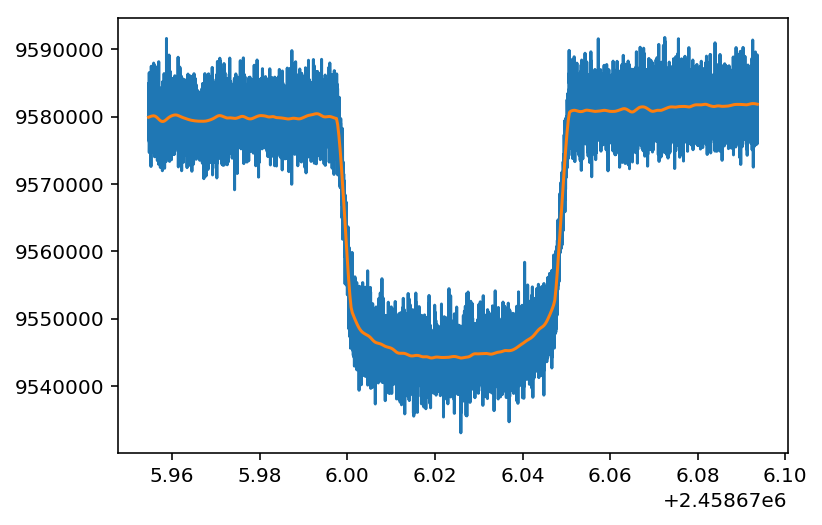

In [220]:
import celerite
from celerite import terms
from scipy.optimize import minimize

initp_dict = dict(amp=np.median(obs_flux), depth=original_params.rp**2, t0=original_params.t0)

parameter_bounds = dict(amp=[np.min(obs_flux), np.max(obs_flux)], 
                        depth=[0.5 * original_params.rp**2, 1.5 * original_params.rp**2],
                        t0=[original_params.t0 - 0.5, original_params.t0 + 0.5])
mean_model = MeanModel(**initp_dict, bounds=parameter_bounds)

x = obs_time
y = obs_flux #/ transit_model(obs_time, original_params)
yerr = obs_err/2

# Set up the GP model
kernel = terms.Matern32Term(log_sigma=np.log(obs_err.mean()), log_rho=np.log(0.01),
                            bounds=dict(log_sigma=(None, None), log_rho=(np.log(0.001), np.log(5))))


# kernel = terms.RealTerm(log_a=-5, log_c=-5)
gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
gp.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, #jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

# Make the maximum likelihood prediction
t = np.linspace(obs_time.min(), obs_time.max(), 500)
mu, var = gp.predict(y, t, return_var=True)
std = np.sqrt(var)

plt.plot(x, y)
# plt.plot(obs_time, obs_flux, '.', zorder=-100, alpha=0.5)
plt.plot(t, mu)
plt.fill_between(t, mu-std, mu+std, alpha=1, zorder=-100)

In [221]:
import emcee

def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(y) + lp

initial = np.array(soln.x)
ndim, nwalkers = len(initial), len(initial) * 2
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 1000)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 500);

Running burn-in...
Running production...


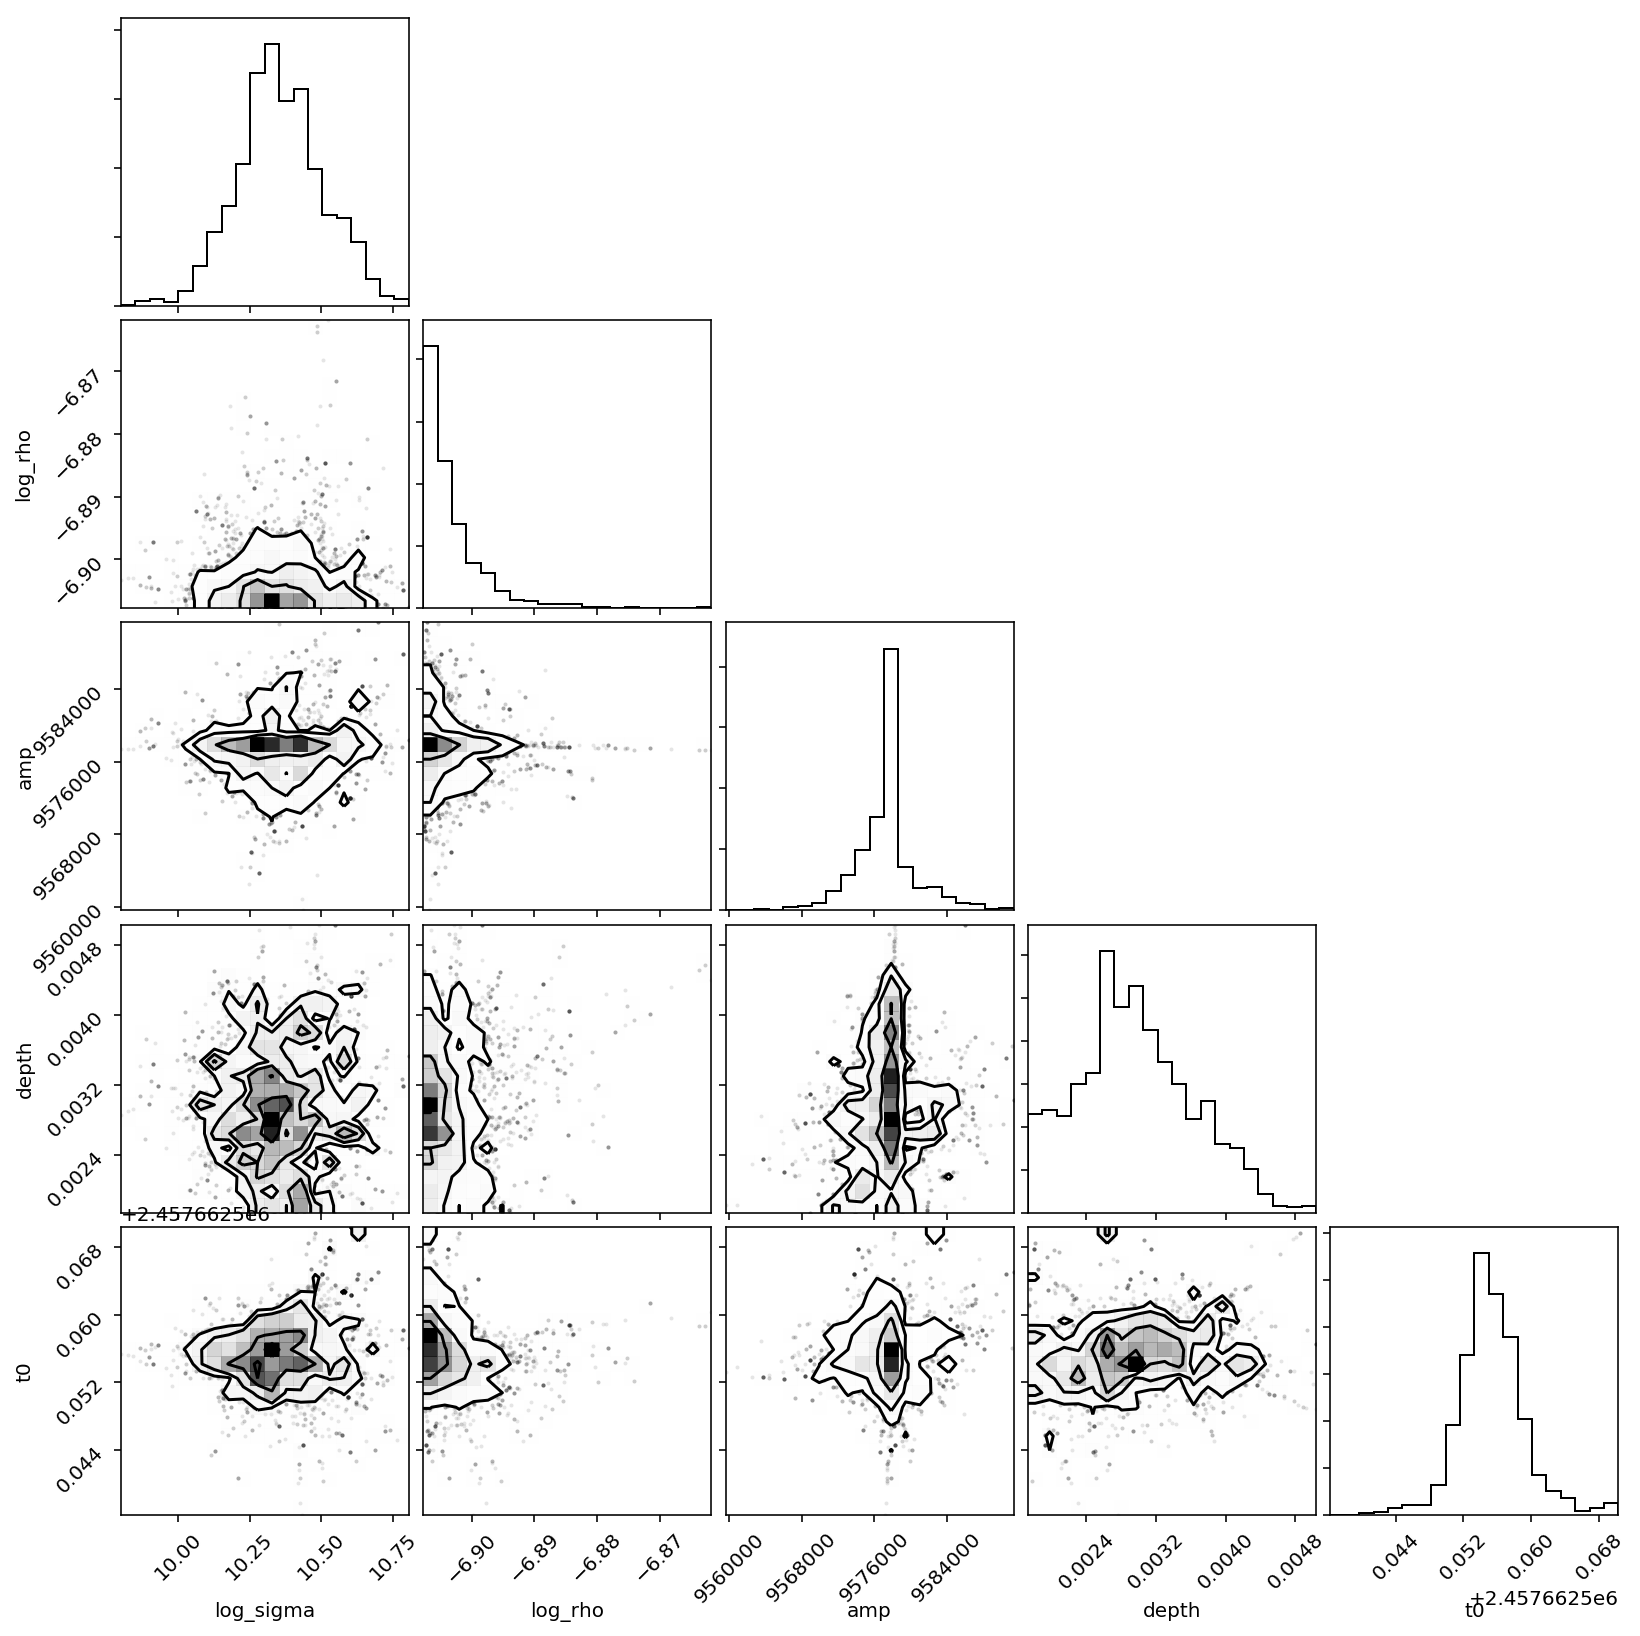

In [228]:
from corner import corner

corner(sampler.flatchain, labels=['log_sigma', 'log_rho', 'amp', 'depth', 't0'])
plt.show()

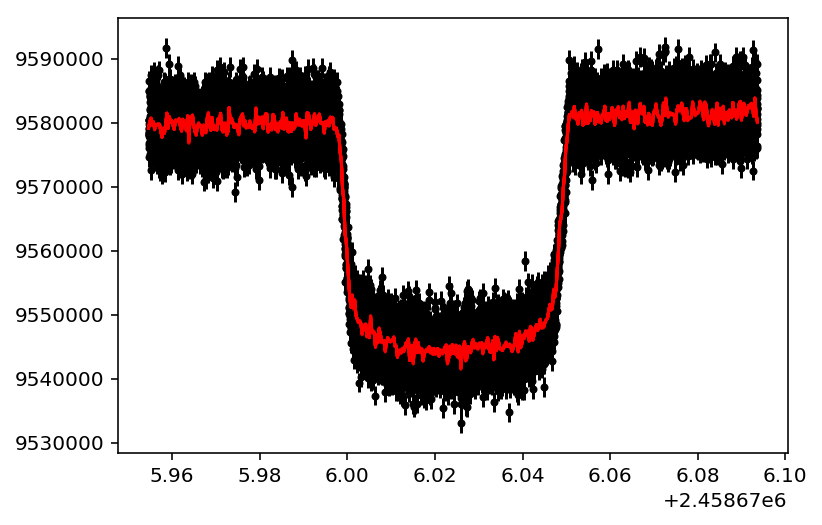

In [229]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", zorder=-100)

samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(y, t, return_cov=False)
    plt.plot(t, mu, color='r', alpha=0.3)